## Интеллектуальный анализ данных – весна 2024
## Домашнее задание 4: kNN. Линейные модели. Работа с признаками

Правила:

* Домашнее задание оценивается в 10 баллов.

* Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.

* Можно использовать любые свободные источники с *обязательным* указанием ссылки на них.

* Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

* Старайтесь сделать код как можно более оптимальным. В частности, будет штрафоваться использование циклов в тех случаях, когда операцию можно совершить при помощи инструментов библиотек, о которых рассказывалось в курсе.  

### Задание 1:  Визуализация решающих поверхностей в kNN.

В этом задании мы изобразим решающую поверхность для классификатора kNN, чтобы наглядно увидеть, как классификатор принимает решения для новых объектов. Для простоты будем работать со встроенным в `sklearn` набором данных `wine`, содержащим информацию о характеристиках трёх видов вина. Описание набора можно найти [здесь](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html#sklearn.datasets.load_wine) и [здесь](https://rdrr.io/cran/rattle.data/man/wine.html).

Загрузим набор данных и сохраним информацию о признаках в переменную `X`, а о зависимой переменной – в переменную `y`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import load_wine

data = load_wine()
X = pd.DataFrame(data['data'], columns = data['feature_names'])
y = data['target']
X.head(8)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
5,14.20,1.76,2.45,15.2,112.0,3.27,3.39,0.34,1.97,6.75,1.05,2.85,1450.0
6,14.39,1.87,2.45,14.6,96.0,2.50,2.52,0.30,1.98,5.25,1.02,3.58,1290.0
7,14.06,2.15,2.61,17.6,121.0,2.60,2.51,0.31,1.25,5.05,1.06,3.58,1295.0


**Задача 1.1 (0.5 балла)** Есть ли в наборе данных пропущенные значения? Если да, то удалите их. Есть ли в наборе данных категориальные переменные? Если да, то закодируйте их при помощи OneHot-кодирования. Используйте [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html).

In [3]:
cat_features_mask = (X.dtypes == "object").values
cat_features_mask.any()

False

In [4]:
X.isna().any()


alcohol                         False
malic_acid                      False
ash                             False
alcalinity_of_ash               False
magnesium                       False
total_phenols                   False
flavanoids                      False
nonflavanoid_phenols            False
proanthocyanins                 False
color_intensity                 False
hue                             False
od280/od315_of_diluted_wines    False
proline                         False
dtype: bool

In [5]:
y.sum()

167

Категориальных признаков в X нет, пропусков тоже. Целевая переменная является категриальной, мы будем решать задачу классификации.

**Задача 1.2 (0.5 балла)** Используя функцию `train_test_split()`, разделите выборку на тренировочную и тестовую, и долю тестовой выборки задайте равной 0.3. Так как разбиение осуществляется случайным образом, не забудьте зафиксировать `np.random.seed()` для воспроизводимости результатов.

Используйте аргумент `stratify` при разбиении. Почему это важно?

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
k = np.random.seed(7777)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=k)

Stratify важно использовать, чтобы не было дисбаланса классов. Дисбаланс классов может повлиять на метрики модели и дать некорректные резульаты (90% точности константной модели, если доля класса 90%)

**Задача 1.3 (1 балл)** На тренировочной выборке обучите шесть классификаторов kNN, отличающихся только числом соседей. Для первого классификатора число соседей поставьте равным 1, для второго - 3, для третьего – 5, для четвертого – 10, для пятого – 15 и для шестого – 25 (обратите внимание на параметр `n_neighbours` класса `KNeighborsClassifier`). Для обучения используйте только два признака: `alcohol` и `magnesium` – и евклидово расстояние. Не забудьте масштабировать признаки, например, при помощи модуля `StandardScaler`.

Выведите долю правильных ответов на тренировочной и тестовой выборках для каждого классификатора.

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[['alcohol', 'magnesium']])
X_test_scaled = scaler.transform(X_test[['alcohol', 'magnesium']])

In [11]:
model1 = KNeighborsClassifier(n_neighbors=1, metric='minkowski', p=2)
model2 = KNeighborsClassifier(n_neighbors=3, metric='minkowski', p=2)
model3 = KNeighborsClassifier(n_neighbors=5, metric='minkowski', p=2)
model4 = KNeighborsClassifier(n_neighbors=10, metric='minkowski', p=2)
model5 = KNeighborsClassifier(n_neighbors=15, metric='minkowski', p=2)
model6 = KNeighborsClassifier(n_neighbors=25, metric='minkowski', p=2)

In [12]:
model1.fit(X_train_scaled, y_train)
model2.fit(X_train_scaled, y_train)
model3.fit(X_train_scaled, y_train)
model4.fit(X_train_scaled, y_train)
model5.fit(X_train_scaled, y_train)
model6.fit(X_train_scaled, y_train)

KNeighborsClassifier(n_neighbors=25)

In [13]:
predict1 = model1.predict(X_test_scaled)
predict2 = model2.predict(X_test_scaled)
predict3 = model3.predict(X_test_scaled)
predict4 = model4.predict(X_test_scaled)
predict5 = model5.predict(X_test_scaled)
predict6 = model6.predict(X_test_scaled)

In [14]:
train_predict1 = model1.predict(X_train_scaled)
train_predict2 = model2.predict(X_train_scaled)
train_predict3 = model3.predict(X_train_scaled)
train_predict4 = model4.predict(X_train_scaled)
train_predict5 = model5.predict(X_train_scaled)
train_predict6 = model6.predict(X_train_scaled)

In [15]:
print("Train accuracy")
print(accuracy_score(y_train, train_predict1))
print(accuracy_score(y_train, train_predict2))
print(accuracy_score(y_train, train_predict3))
print(accuracy_score(y_train, train_predict4))
print(accuracy_score(y_train, train_predict5))
print(accuracy_score(y_train, train_predict6))

Train accuracy
1.0
0.7903225806451613
0.782258064516129
0.7661290322580645
0.7741935483870968
0.7258064516129032


In [16]:
print("Test accuracy")
print(accuracy_score(y_test, predict1))
print(accuracy_score(y_test, predict2))
print(accuracy_score(y_test, predict3))
print(accuracy_score(y_test, predict4))
print(accuracy_score(y_test, predict5))
print(accuracy_score(y_test, predict6))

Test accuracy
0.6481481481481481
0.7222222222222222
0.7407407407407407
0.6666666666666666
0.6481481481481481
0.6851851851851852


**Задача 1.4 (0 баллов)** Установите библиотеку `mlxtend` командой ниже. Библиотеку также можно установить из терминала при помощи `pip` или `conda`, как указано [здесь](http://rasbt.github.io/mlxtend/installation/).

In [ ]:
#!pip install mlxtend

Если всё прошло успешно, то в выводе команды выше вы увидите сообщение вроде "successfully installed", а следующая ячейка выполнится без ошибок.

In [17]:
import mlxtend

**Задача 1.5 (1 балл)** Библиотека `mlxtend` позволяет достаточно просто визуализировать решающие поверхности обученных классификаторов. Изучите [документацию](http://rasbt.github.io/mlxtend/user_guide/plotting/plot_decision_regions/) библиотеки и найдите, как можно построить несколько графиков решающих поверхностей на сетке (decision regions grid). Постройте такую сетку графиков для обученных выше классификаторов.

**Подсказки:**
1. Вы можете использовать готовый код, приведённый в документации, и адаптировать его для нашего случая.
2. Вам могут понадобиться дополнительные библиотеки, которые используются в примере из документации.
3. Обратите внимание на то, как нужно изменить параметры `gridspec.GridSpec()` и `itertools.product()` для нашего числа классификаторов.
4. В функции `plot_decision_region()` используйте `y_train` и нужные столбцы из `X_train`. Возможно, их придётся перевести в формат массива `numpy`.
5. Если в задаче 1.3 вы сохраните обученные классификаторы в список, то не будет необходимости обучать их заново.
6. Построение графика может занять некоторое время – придётся немного подождать!

In [18]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import itertools
from mlxtend.plotting import plot_decision_regions
import numpy as np

KeyboardInterrupt: 

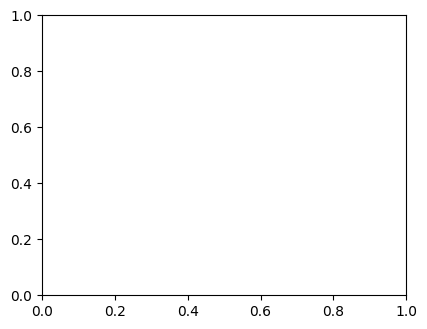

In [19]:
gs = gridspec.GridSpec(2, 3)

fig = plt.figure(figsize=(16, 8))

labels = ['n_1', 'n_2', 'n_3', 'n_4', 'n_5', 'n_6']
for clf, lab, grd in zip([model1, model2, model3, model4, model5, model6],
                         labels,
                         itertools.product([0, 1], [0, 1, 2])):

    #clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_train_scaled, y=y_train, clf=clf, legend=2)
    plt.title(lab)

plt.show()

**Задача 1.6 (0.5 балла)** Прокомментируйте результаты, полученные в задачах 1.3 и 1.5. Какое число соседей оптимально использовать для обучения классификатора? Поясните ваш выбор при помощи описания геометрии данных и получаемой решающей поверхности. Какие из результатов явно говорят о переобучении модели? Почему?

Для обучения классификатора оптимально использовать 3 или 5 соседей. Такой вывод сделан по результатам значений моделей по тестовой выборке(72%-74%) доля верных ответов). На трейне самый высокий результат показывает модель с 1 соседом, но ее показатели значительно падают при тестировании, откуда можем заключить, что модель переобучается при таком значении. Если взять число соседей больше 5 (10 и т.д.), то качество падает до 60%, что напоминает показатели модели с 1 соседом.

Глядя на графики, можно тоже сделать выводы о переобучении. Для 1 соседа на графике заметны несколько точек, которые живут на своих "острвках", что явно говорит о переобучении (видно на примере с одним зеленым объетком). С другой стороны, такие "островки" есть и на моделях с 3 и 5 соседями (не путать с n_3 n_5 - они пронумированы по порядку, а не по количеству соседей).



### Задание 2. KNN своими руками. 2 Балла

В данном задании мы попробуем реализовать алгоритм KNN своими руками. В данном случае мы попробуем сделать KNN для классификации.

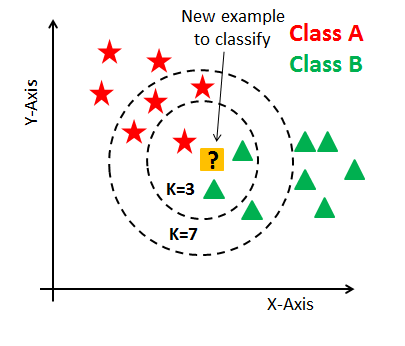

In [20]:
import numpy as np
from collections import Counter

class KNN:
    def __init__(self, k:int):
        self.k = k
        self.values = None
        self.answers = None

    def fit(self, X, y):
      self.values = X
      self.answers = y

    def predict(self, X):
      ans = []
      for element in X:
        d = self.count_distance(self.values, element)
        indexes = np.argsort(d)
        k_closest = self.answers[indexes][:self.k]
        ans.append(Counter(k_closest).most_common()[0][0])

      return np.array(ans)

    def count_distance(self, x, y):
      return np.sqrt(np.sum((x - y)**2, axis=1))

In [21]:
# Не меняйте файл!
def test_knn(KNN):
  knn = KNN(k=1)
  X_train =  np.array([[1, 1], [2, 2]])
  y_train =  np.array([0, 1])
  X_test =  np.array([[1.5, 1.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [0]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[9.5, 9.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5.5, 5.5]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[15, 15]])
  knn.fit(X_train, y_train)
  assert knn.predict(X_test) == [1]

  knn = KNN(k=3)
  X_train = np.array([[1, 1], [2, 2], [3, 3], [4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10]])
  y_train = np.array([0, 0, 0, 0, 1, 1, 1, 1, 1, 1])
  X_test = np.array([[5, 5], [2, 2]])
  knn.fit(X_train, y_train)
  assert all(knn.predict(X_test) == [1, 0])

In [22]:
# Если тесты эти пройдены, то все верно!
test_knn(KNN)

### Задание 3: Линейная регрессия.

В этом задании мы рассмотрим различные аспекты построения линейной модели. Мы будем работать с одним из классических наборов данных в статистике, содержащим информацию о бриллиантах. Описание можно посмотреть [здесь](https://www.kaggle.com/shivam2503/diamonds).

In [23]:
data = pd.read_csv('https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2024/homeworks/hw04_knn_linreg/diamonds.csv')
data.head(5)

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [24]:
data.shape

(53940, 11)

Мы будем решать задачу предсказания цены бриллианта `price` в зависимости от его характеристик.

**Задача 3.1 (0.2 балла)** Есть ли в наборе данных пропущенные значения? Если да, удалите их.
Есть ли в наборе данных бессмысленные столбцы (признаки, не несущие дополнительной информации)? Если да, то удалите их.

In [25]:
data.isna().any()

Unnamed: 0    False
carat         False
cut           False
color         False
clarity       False
depth         False
table         False
price         False
x             False
y             False
z             False
dtype: bool

In [26]:
data = data.drop('Unnamed: 0', axis=1)
data.head(5)

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


Пропусков в данных нет, признак Unnamed не имеет никакого смысла и его можно удалить.

**Задача 3.2 (0.1 балла)** Линейная регрессия основана на предположении о линейной связи между признаками и целевой переменной, а потому перед выбором переменных для включения в модель имеет смысл проверить, насколько эта связь выполняется. Для следующих пунктов нам также потребуются выборочные корреляции между признаками. Выведите матрицу выборочных корреляций между всеми вещественными признаками и целевой переменной (то есть в этой матрице будет $k+1$ строка, где $k$ – количество вещественных признаков).

Какие вещественные признаки коррелируют с целевой переменной больше всего?

In [27]:
data.corr()

<ipython-input-27-c44ded798807>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()


,carat,depth,table,price,x,y,z
carat,1.000000,0.028224,0.181618,0.921591,0.975094,0.951722,0.953387
depth,0.028224,1.000000,-0.295779,-0.010647,-0.025289,-0.029341,0.094924
table,0.181618,-0.295779,1.000000,0.127134,0.195344,0.183760,0.150929
price,0.921591,-0.010647,0.127134,1.000000,0.884435,0.865421,0.861249
x,0.975094,-0.025289,0.195344,0.884435,1.000000,0.974701,0.970772
y,0.951722,-0.029341,0.183760,0.865421,0.974701,1.000000,0.952006
z,0.953387,0.094924,0.150929,0.861249,0.970772,0.952006,1.000000


С целевой переменной price лучше всего коррелируют признаки карат, и значения по x, y, z

**Задача 3.3 (0.1 балла)** Так как линейная модель складывает значения признаков с некоторыми весами, нам нужно аккуратно обработать категориальные признаки. Закодируйте категориальные переменные при помощи OneHot-кодирования.

In [28]:
data = pd.get_dummies(data)
data

,carat,depth,table,price,x,y,z,cut_Fair,cut_Good,cut_Ideal,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,326,3.95,3.98,2.43,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,0.21,59.8,61.0,326,3.89,3.84,2.31,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0.23,56.9,65.0,327,4.05,4.07,2.31,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,0.29,62.4,58.0,334,4.20,4.23,2.63,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,0.31,63.3,58.0,335,4.34,4.35,2.75,0,1,0,...,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53935,0.72,60.8,57.0,2757,5.75,5.76,3.50,0,0,1,...,0,0,0,0,1,0,0,0,0,0
53936,0.72,63.1,55.0,2757,5.69,5.75,3.61,0,1,0,...,0,0,0,0,1,0,0,0,0,0
53937,0.70,62.8,60.0,2757,5.66,5.68,3.56,0,0,0,...,0,0,0,0,1,0,0,0,0,0
53938,0.86,61.0,58.0,2757,6.15,6.12,3.74,0,0,0,...,0,0,0,0,0,1,0,0,0,0


**Задача 3.4 (0.2 балла)** Разделите выборку на тренировочную и тестовую. Долю тестовой выборки укажите равной 0.3. Не забудьте про параметр `stratify`.

In [29]:
from sklearn.model_selection import train_test_split
X, y = data.drop('price', axis=1), data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=np.random.seed(7777))

Не очень ясно как тут применить stratify, так как наша целевая переменная - это целое число и мы решаем задачу регрессии.

**Задача 3.5 (0.3 балла)** Зачастую при использовании линейных моделей вещественные признаки масштабируются. При этом оценки коэффициентов теряют прямую статистическую интерпретацию ("при увеличении $X_1$ на 1, $y$ увеличивается на $w_1$"), но приобретают свойства, полезные в задачах машинного обучения. В этой задаче масштабируйте вещественные признаки тренировочной и тестовой выборок при помощи модуля `StandardScaler`.

In [30]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train[['carat',	'depth',	'table',	'x',	'y',	'z']] = scaler.fit_transform(X_train[['carat',	'depth',	'table',	'x',	'y',	'z']])
X_test[['carat',	'depth',	'table',	'x',	'y',	'z']] = scaler.transform(X_test[['carat',	'depth',	'table',	'x',	'y',	'z']])

**Задача 3.6 (0.2 балла)** Оцените линейную регрессию на тренировочной выборке. Выведите среднеквадратичную ошибку на тренировочной и тестовой выборках.

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lin_regr = LinearRegression()
lin_regr.fit(X_train, y_train)
pred_train = lin_regr.predict(X_train)
pred_test = lin_regr.predict(X_test)

print(f'Train mse: {mean_squared_error(y_train, pred_train)}')
print(f'Test mse: {mean_squared_error(y_test, pred_test)}')

Train mse: 1281557.2135993468
Test mse: 1266040.087620711


**Задача 3.7 (0.2 балла)** Изучите [документацию](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) модуля `LinearRegression` и выведите полученные оценки коэффициентов. Назовите вещественные переменные, оценки коэффициентов которых по модулю на порядок превышают оценки прочих вещественных переменных.

In [32]:
lin_regr.coef_

array([ 5.28245580e+03, -8.40847749e+01, -5.82827609e+01, -1.08924330e+03,
       -2.16713828e+00, -1.63587860e+01, -5.60829778e+02, -1.76854591e+00,
        2.46359571e+02,  1.75228507e+02,  1.41010245e+02,  8.31381698e+02,
        6.12880925e+02,  5.49145975e+02,  3.44196325e+02, -1.54575261e+02,
       -6.40589204e+02, -1.54244046e+03, -3.77155410e+03,  1.52613771e+03,
       -1.58878077e+02, -1.11171331e+03,  7.43502463e+02,  4.41556348e+02,
        1.18943042e+03,  1.14151855e+03])

На порядок отличается вещественная переменная carat - у нее также был самый высокий коэффицент корреляции. Также большие веса есть у признаков категориальных переменных. Самый высокий порядок появляется с коэфициентом 10^3

**Задача 3.8 (0.4 балла)** Как можно заметить из анализа корреляционной матрицы в задаче 3.3, между некоторыми признаками имеется сильная корреляция, что может быть индикатором проблемы *мультиколлинеарности*. Различия в порядке коэффициентов, выявленные в предыдущей задаче также намекают на её присутствие. Как известно, для решения этой проблемы можно либо исключить некоторые признаки из модели, либо использовать регуляризацию. Мы воспользуемся вторым вариантом.

Вспомним, что смысл регуляризации заключается в том, чтобы изменить функцию потерь так, чтобы устранить проблемы, появляющиеся из-за мультиколлинеарности. При L1-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \alpha\sum_{i=1}^k|w_i|
$$

Такая модель называется Lasso-регрессией.

При L2-регуляризации предлагается минимизировать следующую функцию потерь:

$$
\|y - X\hat{w}\|^2 + \frac{1}{2}\alpha\|w\|^2
$$

Такая модель называется Ridge-регрессией.

Обучите Lasso-регрессию и Ridge-регрессию, уставновив гиперпараметр регуляризации равным 10. Для этого используйте модули `Lasso` и `Ridge` из `sklearn`. Сильно ли уменьшились веса? Сделайте вывод о том, насколько сильно проблема мультиколлинеарности проявлялась в изначальной регрессии.

In [33]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

lasso = Lasso(alpha=10)
lasso.fit(X_train, y_train)
lasso_predict_train = lasso.predict(X_train)
lasso_predict_test = lasso.predict(X_test)

ridge = Ridge(alpha=10)
ridge.fit(X_train, y_train)
ridge_predict_train = lasso.predict(X_train)
ridge_predict_test = lasso.predict(X_test)

print(ridge.coef_)
print()
print(lasso.coef_)


[ 5.24379735e+03 -8.15745702e+01 -5.86990611e+01 -1.04050775e+03
 -3.61306593e+00 -2.86640061e+01 -5.63729340e+02 -1.69132793e+00
  2.47483669e+02  1.75321150e+02  1.42615848e+02  8.26587185e+02
  6.09351461e+02  5.45557030e+02  3.42526688e+02 -1.54897825e+02
 -6.37456944e+02 -1.53166759e+03 -3.69984916e+03  1.50674433e+03
 -1.66825897e+02 -1.11521525e+03  7.33470851e+02  4.33133360e+02
  1.17762246e+03  1.13091931e+03]

[ 4807.45093171   -92.66408954   -77.11864003  -676.8104292
    -0.           -29.41111819  -410.18881853   -30.19544098
    88.12037511     0.             0.           339.8131111
   163.79601077   109.59639757     0.          -436.07287849
  -857.49139849 -1653.89667321 -3513.85580208   693.70486905
  -629.09614368 -1520.44290186   142.98814176   -21.22370403
   522.03449366   528.01733056]


Для Ridge регрессии веса почти не изменились, порядок тот же, числа почти не отличаются. Lasso регрессия показала небольшие изменения, но порядок остался тот же. Скорее всего, проблема мультиколлениарности не была такой значительной в изначальной регресии.

**Задача 3.9 (0.4 балла)** Как обсуждалось на семинарах, Lasso-регрессию можно использовать для отбора наиболее информативных признаков. Для следующих значений параметра регуляриазции $\alpha$: 0.1, 1, 10, 100, 200 –  обучите Lasso- и Ridge-регрессии и постройте график измненения евклидовой нормы весов (`np.linalg.norm()` от вектора оценок коэффициентов) в зависимости от параметра $\alpha$. Как известно, норма является численной характеристикой величины вектора, а потому по норме можно судить о том, насколько большие элементы содержит вектор оценок коэффициентов.

Какой метод агрессивнее уменьшает веса? Поясните, почему Lasso-регрессию часто используют для отбора признаков.

In [34]:
weights_lasso = []
weights_ridge = []
gammas = [0.1, 1, 10, 100, 200]

for gamma in gammas:
  ridge = Ridge(alpha=gamma)
  lasso = Lasso(alpha=gamma)
  ridge.fit(X_train, y_train)
  lasso.fit(X_train, y_train)
  weights_lasso.append(np.linalg.norm(lasso.coef_))
  weights_ridge.append(np.linalg.norm(ridge.coef_))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.338e+07, tolerance: 5.982e+07
  model = cd_fast.enet_coordinate_descent(


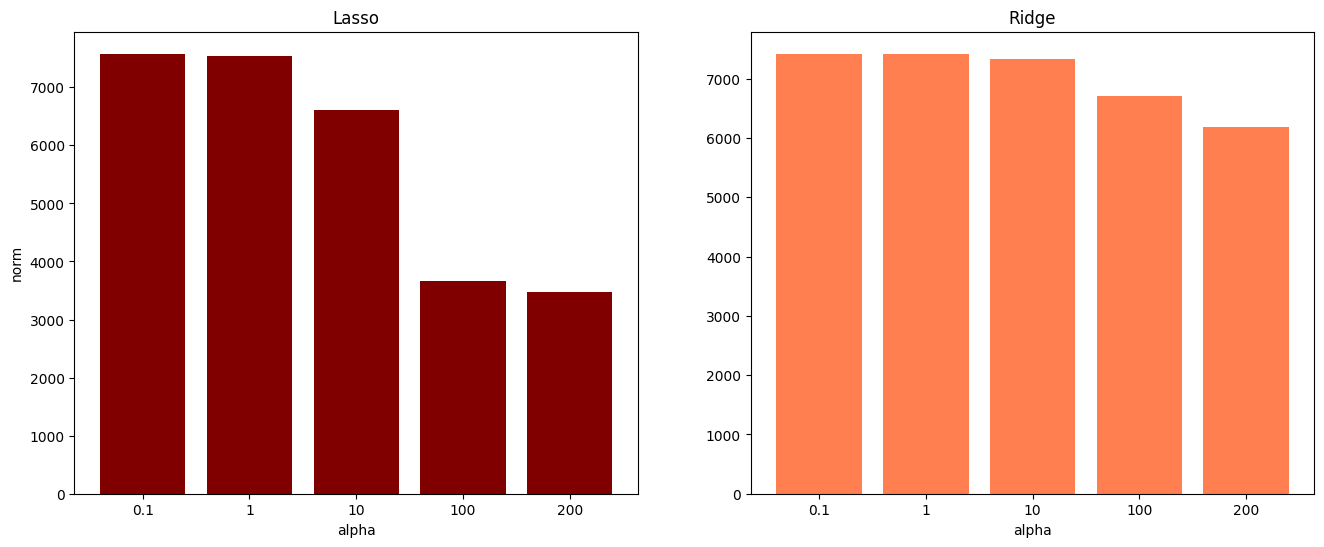

In [35]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.bar(list(map(str, gammas)), np.array(weights_lasso), color='maroon')
plt.xlabel('alpha')
plt.ylabel('norm')
plt.title('Lasso')

plt.subplot(1, 2, 2)
plt.bar(list(map(str, gammas)), np.array(weights_ridge), color='coral')
plt.xlabel('alpha')
plt.title('Ridge')

plt.show()

Агрессивнее уменьшает веса Lasso регрессия. Это можно заметить на графиках, где при значении альфа = 100 и 200 Lasso регрессия уменьшает норму до 3500, в то время как Ridge регрессия при таком же альфа доходит только до примерно 6500-7000.

Одним из частых самых объяснений явления отбора признаков Lasso регрессией звучит так. Модуль нормы весов на графике предстваляет собой ромб с центром в начале координат. В свою очередь, Rdige регрессия со своим квадратом нормы предствляет собой окружность. Таким образом, при приближении к своему локальному или глобальному минимуму, линии уровня нашей функции в Ridge регрессии с большей вероятностью попадут на саму окружность, а в Lasso регресии они вероятнее попадут в углы ромба, где один или несколько признаков зануляются. Такое объяснение не является строгим, но позволяет интуитивно понять суть подхода Lasso регресии


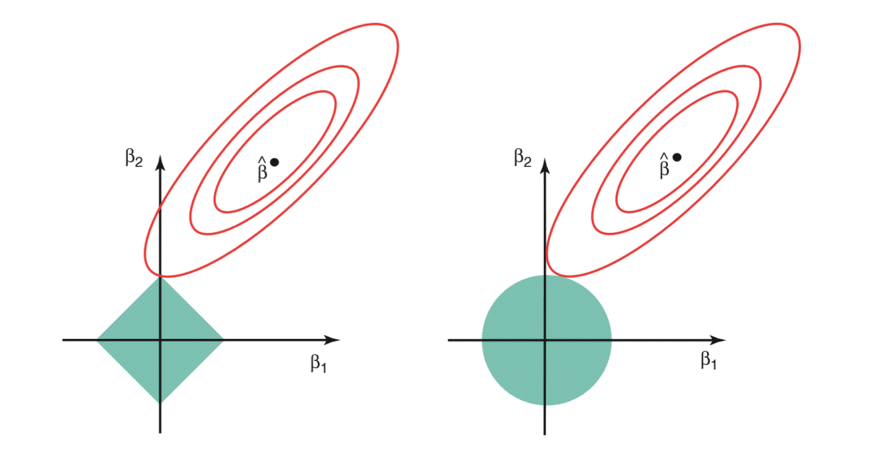

**Задача 3.10 (0.5 балла)**
В зависимости от значения параметра $\alpha$ в Lasso-регрессии зануляются разные оценки коэффициентов. Оптимальное значение $\alpha$ можно подобрать, например, при помощи кросс-валидации по тренировочной выборке.

Для проведения кросс-валидации можно использовать модуль `LassoCV`. Этот модуль принимает список значений $\alpha$ (параметр `alphas`) и при обучении проводит кросс-валидацию для каждого значения из этого списка, сохраняя MSE на каждом участке кросс-валидации (количество участков – параметр `cv`) в матрицу ошибок (то есть итоговая матрица будет иметь размер `len(alphas)` $\times$ `cv`). После обучения модели матрицу ошибок можно получить, обратившись к атрибуту `.mse_path_`.

Заметим, что модель может использовать $\alpha$ не в том порядке, в котором вы подаёте их в функцию: для определения порядка используйте атрибут `.alphas_` Установите количество участков для кросс-валидации (параметр `cv`) равным 5.

Усредните ошибки для каждого значения $\alpha$ (то есть по строкам матрицы ошибок) и выберите то значение, которое даёт наибольшее качество.

In [36]:
from sklearn.linear_model import LassoCV

parametrs = list(range(1, 10)) + list(range(10, 101, 10))
lasso_cv = LassoCV(alphas=parametrs, cv=5)
lasso_cv.fit(X_train, y_train)

LassoCV(alphas=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90,
                100],
        cv=5)

In [37]:
np.mean(lasso_cv.mse_path_, axis=1).shape

(19,)

In [38]:
mean_errors = np.mean(lasso_cv.mse_path_, axis=1)

print(lasso_cv.alphas_)
print(mean_errors)
print(f'MSE: {mean_errors[np.argsort(mean_errors)[0]]}')
print(f'alpha = {lasso_cv.alphas_[np.argsort(mean_errors)[0]]}')

[100  90  80  70  60  50  40  30  20  10   9   8   7   6   5   4   3   2
   1]
[2225731.23979769 2181360.98891973 2140316.027898   2087445.53556933
 2008312.70242949 1886766.68727293 1720380.851065   1579086.02885508
 1429284.31897711 1322989.89738653 1316081.22400081 1309912.05843668
 1304489.19097154 1299806.9881647  1295864.44375229 1292658.14170123
 1290160.94480547 1288404.01964836 1287395.96022641]
MSE: 1287395.9602264105
alpha = 1


Для дополнительной проверки были добавлены еще значения для альфа, изначально эксперементы проводились с данными 5 значениями, но на ответ это не повлияло, лучшее значение остается 1.

**Задача 3.11 (0.5 балла)** Обучите итоговую Lasso-регрессию с выбранным параметром $\alpha$ на тренировочной выборке. Выведите полученные коэффициенты и прокомментируйте, какие признаки оказались неинформативными, а какие – наиболее информативными. Приведите возможное смысловое объяснение этого результата.

In [39]:
lasso_best = Lasso(alpha=1)
lasso_best.fit(X_train, y_train)

Lasso(alpha=1)

In [40]:
lasso_best.score(X_test, y_test)

0.9211644152132491

In [41]:
pd.DataFrame(data=lasso_best.coef_, index=X.columns)

,0
carat,5235.158229
depth,-84.869361
table,-60.033934
x,-1048.731375
y,-0.000000
z,-18.952689
cut_Fair,-673.962354
cut_Good,-132.990641
cut_Ideal,102.330421
cut_Premium,28.011924


При первом же взгляде на приведенную выше таблице очевидно, что самым значимым признаком оказалось количество карат - вес при это признаке наибольший. Признаки depth, table почти не играют роли, их веса очень малы, как и веса y, z.
С другой стороны, вес параметра x достаточно большой и при это отрицательный. Возможно, что одного значений x достаточно, или связь признаков нелинейная, здесь сказать трудно. С категориальными признаками нужно быть осторожно, так как их наличие может встречаться не так часто и модель может быть гиперчувтсвительна к ним. Признак cut показывает разные значения в зависимости от категории, значение "Very Good" вообще занулилось, а наиоболее значимым видом этого признака оказалось значение "Fair". Почему так остается только догадываться. Признак цвета имеет схожую ситуацию, есть занулившийся признак и большой отрицательный признак. Возможно, что наличие цвета J сигнализирует о низкой цене. Наконец, в признаке прозрачности выделяются две категории SI2, I1. Оба имеют большое абсолютное значение и оба отрицательны, что может сигнализировать о низкой цене как в предыдущем случае.

**Задача 3.12 (0.4 балла)** Сделайте предсказания обученной Lasso-регрессии на тестовой выборке и сравните среднеквадратичную ошибку с ошибкой обычной линейной регрессии из задачи 3.7. Какую модель лучше использовать для предсказаний? Приведите возможное объяснение, почему одна модель оказалась лучше другой.

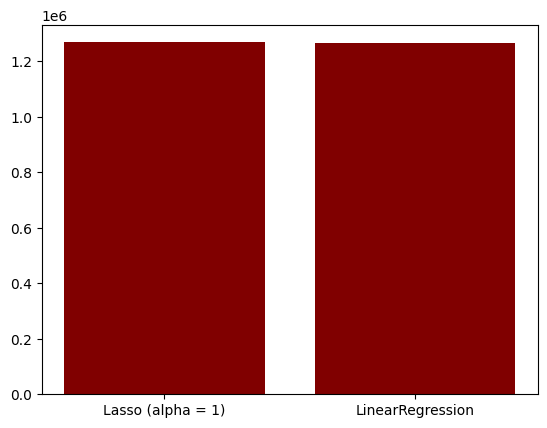

In [42]:
best_mse = mean_squared_error(y_test, lasso_best.predict(X_test))
base_mse = mean_squared_error(y_test, pred_test)

plt.bar(['Lasso (alpha = 1)', 'LinearRegression'], [best_mse, base_mse], color='maroon')
plt.show()

In [43]:
print(best_mse)
print(base_mse)

1267656.731630648
1266040.087620711


Показатели линейной регрессии с и без регуляризации оказалось схожими. Оба показывают почти одинаковые результаты, отиличие может быть просто погрешностью. Одно из возможных объяснений - это что модели не так сильно нужна регуляризация. Веса у модели не такие уж и большие, поэтому сооброжение о переобучении на больших весах здесь не применимо. Зануление каких-то признаков тоже не повлияло на точность, там, где модель занулила много объектов, ошибка оказалась на порядок больше.